In [23]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import permutations

# algorithm

def GraphAnon(edgeList,K=3):

    'executes graph anaonymization algorithm 1.'

    logFile=open("Edges.txt","w")

    # graph creation

    graph=nx.Graph()

    graph.add_edges_from(edgeList)

    edgesOriginal=len(edgeList)

    nodesOriginal=len(graph.nodes())

    # 1. cut vertices

    cutVertices=list(nx.articulation_points(graph))

    # 2. bridges

    bridges=list(nx.bridges(graph))

    # 3. average degree

    avgDegree=len(graph.edges())/len(graph.nodes())

    

    degrees={}

    # frequency calculations
    nodes=list(graph.nodes)
    freq=[]
    for n in nodes:
        adjLength=len(list(graph.adj[n]))
        if str(adjLength) not in degrees.keys():
           degrees[str(adjLength)]=1
        elif adjLength in degrees.keys():
            degrees[str(adjLength)]+=1
        freqWeight=adjLength/len(nodes)
        freq.append(freqWeight)
    
    # maximum frequency

    freqMax=max(freq)


    if round(avgDegree)!=avgDegree:
        avgDegree=round(avgDegree+1)
    
    print("Executing Graph anonymization algorithm.")
    print('Average degree:',avgDegree)
    print('Bridges:',bridges)
    print("Cut Vertices:",cutVertices)
    print("Frequency:",freqMax)

    # edges by strength

    strongEdges,weakEdges=EdgesByStrength(graph=graph,freqMax=freqMax)

    print("Strong Edges:",strongEdges)

    print("Weak Edges:",weakEdges)
    
    # 4. Edges among cut vertices

    if len(cutVertices)!=0 :

        noMaxEdges=int((len(cutVertices)*(len(cutVertices)-1))/2)

        print('Executing step 4.')

        edgesAdded=0
        for i in range(len(cutVertices)):
            for j in cutVertices[i+1:]:
                if (cutVertices[i],j) not in list(graph.edges()) and edgesAdded<noMaxEdges:
                    graph.add_edge(cutVertices[i],j,createdAt='step4')
                    edgesAdded+=1
    
    # 5. New nodes for each bridge
    
    if len(bridges)!=0:

        dbNodes=[]
        print('Executing step 5.')
        i=1
        for k,v in bridges:
            e1=[('d'+str(i),k),('d'+str(i),v)]
            dbNodes.append('d'+str(i))
            for e in e1:
                if e not in list(graph.edges()):
                    #stp2Edges.append(e)
                    graph.add_edge(e[0],e[1],createdAt='step5')
            i+=1
    
    # 6. Step6

    if len(bridges)!=0:

        print('Executing step 6.')

        for a,b in bridges:

            edgeToAdd=Step6(a=a,b=b,graph=graph,avgDegree=avgDegree,threshold=freqMax)

            if len(edgeToAdd)!=0:
                graph.add_edge(edgeToAdd[0],edgeToAdd[1],createdaAt='step6')


    
    
    # 7.Duplicate nodes for cut vertices.

    if len(cutVertices)!=0 :
        print('Executing step 7.')   

        step7Edges=[]
        d1Nodes=[]
        for v in cutVertices:
            step7Edges.append(("V->"+str(v),v))
            d1Nodes.append("V->"+str(v))

        if len(cutVertices)>1:
            step7_1Edges=[]
            for i in range(len(step7Edges)):
                if i==len(step7Edges)-1:
                    step7_1Edges.append((step7Edges[i][0],step7Edges[0][0]))
                else:
                    step7_1Edges.append((step7Edges[i][0],step7Edges[i+1][0]))
            step7Edges+=step7_1Edges
        
        for a,b in step7Edges:
            graph.add_edge(a,b,createdAt="step7")


    cVert=list(nx.articulation_points(graph))

    noEdgesAddMax=1

    

    for c in cVert:

        cAdjNodes=list(graph.adj[c])

        edgeFlag=0

        for cAdjNode in cAdjNodes:

            edgeAddC=Step6(a=c,b=cAdjNode,avgDegree=avgDegree,threshold=freqMax,graph=graph)

            if len(edgeAddC)!=0 and edgeFlag<noEdgesAddMax:
                
                graph.add_edge(edgeAddC[0],edgeAddC[1],createdAt='SilenceCVert')
                graph.add_edge(edgeAddC[0],"V->"+str(c),createdAt="SilenceCVert")
                graph.add_edge(edgeAddC[1],'V->'+str(c),createdAt='SilenceCVert')

                edgeFlag+=1
    

    
    cVert2=list(nx.articulation_points(graph))

    for cv in cVert2:
        dupNode="V->"+str(cv)
        for d1 in d1Nodes:
            graph.add_edge(cv,d1,createdAt="SilenceCVert")
            graph.add_edge(dupNode,d1,createdAt="SilenceCVert")
    


    # Step 8 (2021-09-07)

    print('Executing step 8.') 

    u=[x for x in list(graph.nodes) if len(graph.adj[x])<K]

    print("U:",u)

    ls=[1,2,3]

    for l in ls:

        graph=PrivacyPara(l=l,u=u,k=K,graph=graph)

        logFile.write("K:%d;L:%d;\nEdges:%s"%(K,l,str(graph.edges())))

        logFile.write("\n")

        #print("Edges:",graph.edges())

    

    # 9. add edges among non adjacent nodes

    if len(cutVertices)==0 and len(bridges)==0:

        print('Executing step 9.') 
        
        nodesGDegree=[x for x in list(graph.nodes) if len(graph.adj[x])>=avgDegree]

        step8EdgesPrep=[]

        edgeCount=0
        for i in range(len(nodesGDegree)):
            if edgeCount>=avgDegree:
                break
            for node in nodesGDegree[i+1:]:
                if (nodesGDegree[i],node) not in graph.edges() and edgeCount<avgDegree:
                    step8EdgesPrep.append((nodesGDegree[i],node))
                    edgeCount+=1
                elif edgeCount>=avgDegree:
                    break
        
        step8Edges=[]
        dupNodes=[]
        for a,b in step8EdgesPrep:
            if str(a)+'*' not in dupNodes:
                dupNodes.append(str(a)+"*")
                step8Edges+=[(str(a)+'*',a),(str(a)+'*',b)]
            else:
                dupNodes.append(str(b)+'*')
                step8Edges+=[(str(b)+"*",a),(str(b)+'*',b)]
        
        for a,b in step8Edges:
            graph.add_edge(a,b,createdAt="step9")

    # 2. edges

    colorEdges=[]

    nEdgesAdded=0
    nEdgesAddedCutVert=0

    for a,b,r in graph.edges.data('createdAt'):
        if r==None:
            colorEdges.append('black')
        elif r=="SilenceCVert":
            colorEdges.append('red')
        
        elif r=='step4' :
            colorEdges.append('yellow')
            nEdgesAdded+=1
            nEdgesAddedCutVert+=1
        elif r=="step5":
            colorEdges.append('green')

        else:
            colorEdges.append("blue")
            nEdgesAdded+=1
    
    # 1. nodes

    colorNodes=[]
    for node in graph.nodes():
        if node in cutVertices:
            colorNodes.append("red")
        else:
            colorNodes.append('green')

        

        
    nx.draw(graph,with_labels=True,node_size=1000,edge_color=colorEdges,node_color=colorNodes)  # networkx draw()edge_size=500
    print(plt.draw()) 

    noEdgesAdded=len(graph.edges())-edgesOriginal

    nodesAdded=len(graph.nodes())-nodesOriginal

    print("No of Edges Added:",noEdgesAdded)

    print("No of duplicate nodes:",nodesAdded)

    logFile.close()
    
    return list(graph.edges())


def Step6(a,b,graph,threshold,avgDegree):

    'builds relationship based on neighbourhood'

    adjParent=list(graph.adj[a])
    adjNode=list(graph.adj[b])

    cond1NodesA=[x for x in adjParent if len(graph.adj[x])>=avgDegree]
    cond1NodesB=[x for x in adjNode if len(graph.adj[x])>=avgDegree]

    if len(cond1NodesA):
        cond1NodesA=adjParent

    if len(cond1NodesB):
        cond1NodesB=adjNode
    
    edgeAdd=()
    
    for parent in cond1NodesA:

        adjParent1=list(graph.adj[parent])

        for node in cond1NodesB:
            #print("".ljust(25,'*'))
            if node == parent:
                continue
            adjNode1=list(graph.adj[node])
            #commonNeighbours=[x for x in adjParent1 if x in adjNode1]
            commonNeighbours=list(set(adjParent1).intersection(adjNode1))
            try:            
                neighValue=len(commonNeighbours)/((len(adjParent1)-1)+(len(adjNode1)-1)-len(commonNeighbours))
            except ZeroDivisionError:
                continue
            if (parent,node) not in graph.edges() and parent !=node:
                if len(edgeAdd)==0:
                    edgeAdd=(parent,node,neighValue)
                elif len(edgeAdd)!=0 and neighValue<edgeAdd[2]:
                    edgeAdd=(parent,node,neighValue)
    
    return edgeAdd



def PrivacyPara(l,u,k,graph):

    "executes step added on date 2021-09-07"

    noEdgesAdded=0

    for alpha in u:

        #print("U Parameter:",alpha)

        adjAlpha=list(graph.adj[alpha])

        adjPairs=GetCombinations(adjAlpha,l)

        # print("L:",l)

        # print("Adj Pairs:",adjPairs)

        for adjPair in adjPairs:        

            # iterating adjacent pairs

            if l==1:

                nodesUnion=u

                degreeCond=len([x for x in list(graph.adj[adjPair[0]]) if x != alpha])
                
            
            elif l==2:

                nodesUnion=list(graph.adj[adjPair[0]])+list(graph.adj[adjPair[1]])

                adjPairN1=[x for x in list(graph.adj[adjPair[0]]) if x != alpha]

                adjPairN2=[x for x in list(graph.adj[adjPair[1]]) if x != alpha]

                degreeCond=len([x for x in adjPairN1 if x in adjPairN2])


            else:

                nodesUnion=list(graph.adj[adjPair[0]])+list(graph.adj[adjPair[1]])+list(graph.adj[adjPair[2]])

                adjPairN1=[x for x in list(graph.adj[adjPair[0]]) if x != alpha]

                adjPairN2=[x for x in list(graph.adj[adjPair[1]]) if x != alpha]

                adjPairN3=[x for x in list(graph.adj[adjPair[2]]) if x != alpha]

                degreeCond=len([x for x in adjPairN1 if x in adjPairN2 and x in adjPairN3])

            
            nodesUnion=list(set(nodesUnion))

            scopeDF=pd.DataFrame({"Node":nodesUnion,"Degree":[len(graph.adj[x]) for x in nodesUnion]})

            scopeDF.sort_values(by="Degree",inplace=True,ignore_index=True)

            nodesToChoose=[x for x in list(scopeDF.Node) if x !=alpha and x not in adjPair]

            
            # if l>1:
            #     print("adjPair:",adjPair)
            #     print("degree Cond:",degreeCond)

            if degreeCond<k:

                noIters=k-degreeCond

                for iter in range(noIters):

                    for n in list(adjPair):

                        if iter <len(nodesToChoose) and set([n,nodesToChoose[iter]]) not in [set(list(x)) for x in list(graph.edges)]:

                            # print("adding relationships")

                            # print(alpha)

                            # print(set([n,nodesToChoose[iter]]))

                            noEdgesAdded+=1

                            graph.add_edge(n,nodesToChoose[iter],createdAt="step8")
    



    print("L:",l)

    print("K:",k)

    print("Num of Edges Added:",noEdgesAdded)


    return graph



def GetCombinations(items,l):

    'get unique combination of items for l'

    coms=list([set(x) for x in permutations(items,l)])

    comsUnique=[]

    for com in coms:

        if com not in comsUnique:

            comsUnique.append(com)
    
    comsUnique=[list(x) for x in comsUnique]

    return comsUnique


def EdgesByStrength(graph,freqMax):

    "returns edges into two categories i.e strong and weak edges."

    strongEdges=[]

    weakEdges=[]

    for a,b in graph.edges():

        adjParent=list(graph.adj[a])

        adjChild=list(graph.adj[b])

        commonNeighbours=list(set(adjParent).intersection(adjChild))
        try:            
            neighValue=len(commonNeighbours)/((len(adjParent)-1)+(len(adjChild)-1)-len(commonNeighbours))

            if neighValue>=freqMax:

                strongEdges.append((a,b))
            
            else:

                weakEdges.append((a,b))
        
        except Exception:
            pass
    

    return strongEdges,weakEdges
        










In [2]:
set([1,5,4]) in [set([5,1,4])]

True

In [2]:
import pandas as pd

In [30]:
dataset=pd.read_csv("email.csv")
edgeList=[(dataset['a'][x],dataset['b'][x])for x in range(len(dataset))]
edgeList

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (1, 26),
 (1, 27),
 (1, 28),
 (1, 29),
 (1, 30),
 (1, 31),
 (2, 18),
 (2, 32),
 (2, 13),
 (2, 16),
 (2, 10),
 (2, 24),
 (2, 33),
 (2, 34),
 (2, 22),
 (2, 1),
 (2, 35),
 (2, 3),
 (2, 9),
 (2, 20),
 (2, 36),
 (2, 7),
 (2, 6),
 (2, 8),
 (2, 37),
 (2, 11),
 (2, 4),
 (2, 38),
 (2, 19),
 (3, 39),
 (3, 21),
 (3, 40),
 (3, 13),
 (3, 2),
 (3, 1),
 (3, 7),
 (3, 8),
 (3, 34),
 (3, 28),
 (3, 23),
 (3, 41),
 (3, 42),
 (3, 43),
 (3, 9),
 (3, 11),
 (3, 4),
 (3, 18),
 (3, 19),
 (3, 44),
 (3, 16),
 (3, 45),
 (3, 46),
 (3, 6),
 (3, 20),
 (3, 27),
 (3, 22),
 (3, 47),
 (3, 48),
 (3, 49),
 (3, 50),
 (3, 12),
 (3, 51),
 (3, 52),
 (3, 53),
 (3, 54),
 (3, 55),
 (3, 56),
 (4, 57),
 (4, 58),
 (4, 59),
 (4, 1),
 (4, 60),
 (4, 46),
 (4, 61),
 (4, 3),
 (4, 62),
 (4, 63),
 (4, 64),
 (4,

In [24]:
g=nx.read_gml("karate.gml",label='id')
edgeList=list(g.edges())

Executing Graph anonymization algorithm.
Average degree: 3
Bridges: [(1, 12)]
Cut Vertices: [1]
Frequency: 0.5
Strong Edges: [(4, 8), (4, 14), (6, 7), (33, 34)]
Weak Edges: [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (1, 12), (1, 13), (1, 14), (1, 18), (1, 20), (1, 22), (1, 32), (2, 3), (2, 4), (2, 8), (2, 14), (2, 18), (2, 20), (2, 22), (2, 31), (3, 4), (3, 8), (3, 9), (3, 10), (3, 14), (3, 28), (3, 29), (3, 33), (4, 13), (5, 7), (5, 11), (6, 11), (6, 17), (7, 17), (9, 31), (9, 33), (9, 34), (14, 34), (20, 34), (32, 25), (32, 26), (32, 29), (32, 33), (32, 34), (31, 33), (31, 34), (10, 34), (28, 24), (28, 25), (28, 34), (29, 34), (33, 15), (33, 16), (33, 19), (33, 21), (33, 23), (33, 24), (33, 30), (34, 15), (34, 16), (34, 19), (34, 21), (34, 23), (34, 24), (34, 27), (34, 30), (24, 26), (24, 30), (26, 25), (30, 27)]
Executing step 4.
Executing step 5.
Executing step 6.
Executing step 7.
Executing step 8.
U: [12, 13, 18, 22, 10, 17, 15, 16, 19, 21, 23, 27]


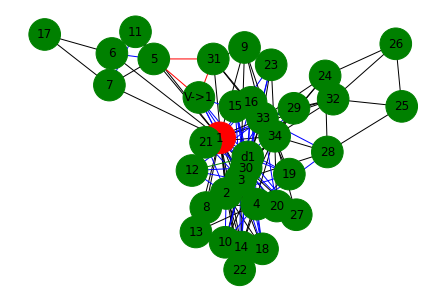

In [25]:
e1=GraphAnon(edgeList)

In [15]:
logFile=open("Edges.txt","w")

In [12]:
logFile.write("K:3;L:1 \n Edges:")

16

In [13]:
logFile.close()

Executing Graph anonymization algorithm.
Average degree: 11
Bridges: []
Cut Vertices: [658]
Frequency: 0.24084507042253522
Executing step 4.
Executing step 7.
None
No of Edges Added: 2
No of duplicate nodes: 0


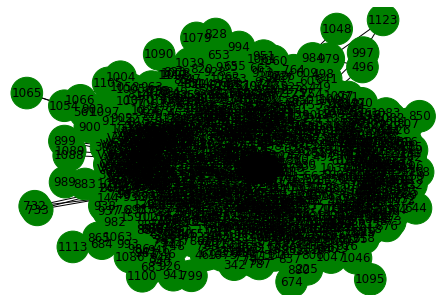

In [24]:
e4=GraphAnon(e3)